In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
import shap
import sweetviz as sv
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from tpot import TPOTClassifier

In [82]:
df = pd.read_csv('../Patient No Show/patient_no_show_dataset.csv')

# Problem List
- 

# Data Overview

In [83]:
df.head(10)

,Patient ID,Age,gender,Ethnicity,Socioeconomic Status,Distance to Facility,Previous No-shows,Appointment No-show
0,1,56,Female,Ethnicity C,Low,3.13,1,No
1,2,69,Male,Ethnicity C,Low,10.81,2,Yes
2,3,46,Non-Binary,Ethnicity D,Medium,15.94,0,Yes
3,4,32,Female,Ethnicity A,Low,18.91,0,No
4,5,60,Male,Ethnicity A,Low,15.19,3,No
5,6,25,Male,Ethnicity A,High,14.69,2,Yes
6,7,78,Male,Ethnicity B,High,16.70,0,No
7,8,38,Female,Ethnicity C,Low,9.48,0,Yes
8,9,56,Non-Binary,Ethnicity A,Medium,16.31,0,Yes
9,10,75,Male,Ethnicity D,High,1.15,1,Yes


In [84]:
df.describe()

,Patient ID,Age,Distance to Facility,Previous No-shows
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,50.380000,10.575860,0.975000
std,288.819436,18.378666,5.451377,1.012621
min,1.000000,18.000000,1.030000,0.000000
25%,250.750000,35.000000,5.835000,0.000000
50%,500.500000,50.000000,10.730000,1.000000
75%,750.250000,66.000000,15.375000,2.000000
max,1000.000000,80.000000,19.950000,5.000000


In [85]:
mapping = {'Female': 0, 'Male': 1}
df['gender'] = df['gender'].map(mapping)

mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['Socioeconomic Status'] = df['Socioeconomic Status'].map(mapping)

mapping = {'No': 0, 'Yes': 1}
df['Appointment No-show'] = df['Appointment No-show'].map(mapping)

mapping = {'Ethnicity A': 1, 'Ethnicity B': 2, 'Ethnicity C': 3, 'Ethnicity D': 4}
df['Ethnicity'] = df['Ethnicity'].map(mapping)

df.drop(['Patient ID'], axis=1, inplace=True)

In [86]:
df.head(10)

,Age,gender,Ethnicity,Socioeconomic Status,Distance to Facility,Previous No-shows,Appointment No-show
0,56,0.0,3,1,3.13,1,0
1,69,1.0,3,1,10.81,2,1
2,46,NaN,4,2,15.94,0,1
3,32,0.0,1,1,18.91,0,0
4,60,1.0,1,1,15.19,3,0
5,25,1.0,1,3,14.69,2,1
6,78,1.0,2,3,16.70,0,0
7,38,0.0,3,1,9.48,0,1
8,56,NaN,1,2,16.31,0,1
9,75,1.0,4,3,1.15,1,1


# Data Visualisation

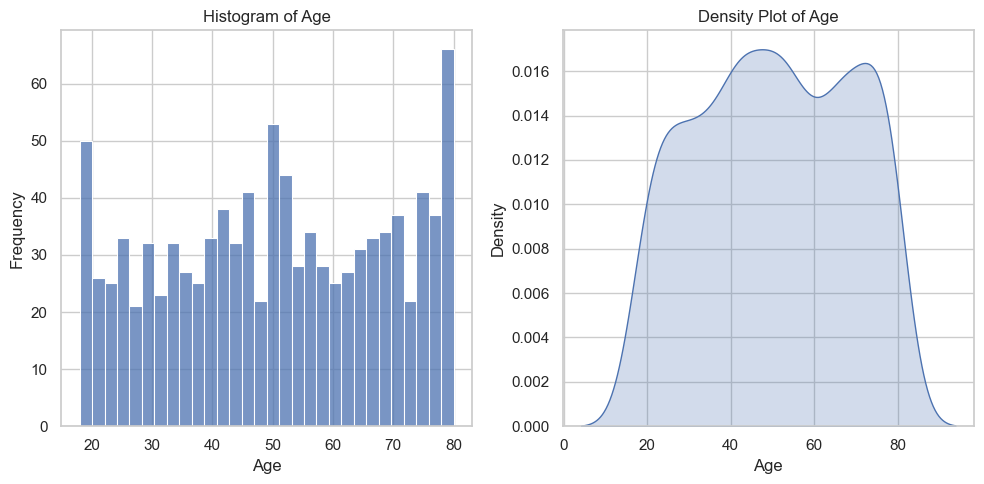

Statistics for Age:
count    1000.000000
mean       50.380000
std        18.378666
min        18.000000
25%        35.000000
50%        50.000000
75%        66.000000
max        80.000000
Name: Age, dtype: float64

Skewness: -0.06131207361588635

Kurtosis: -1.1659864966860534




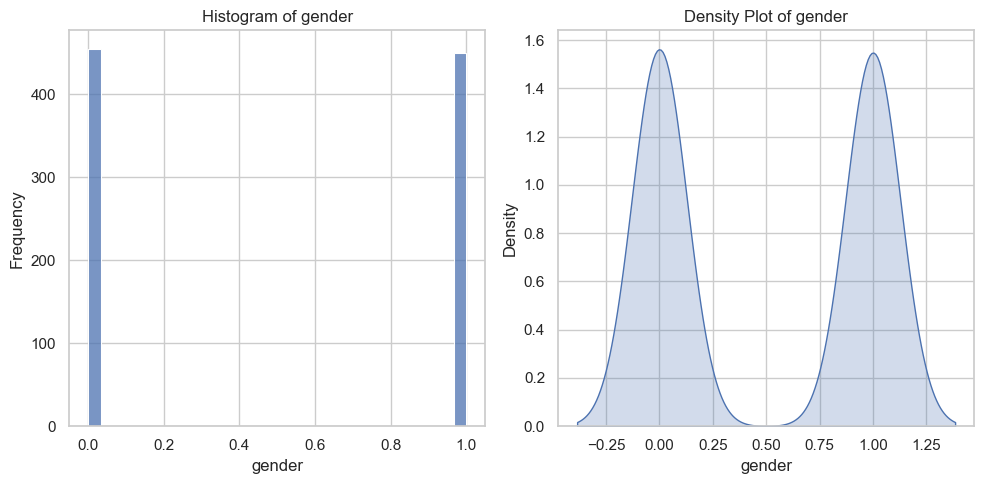

Statistics for gender:
count    904.000000
mean       0.497788
std        0.500272
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: gender, dtype: float64

Skewness: 0.008864359500427034

Kurtosis: -2.0043607605558456




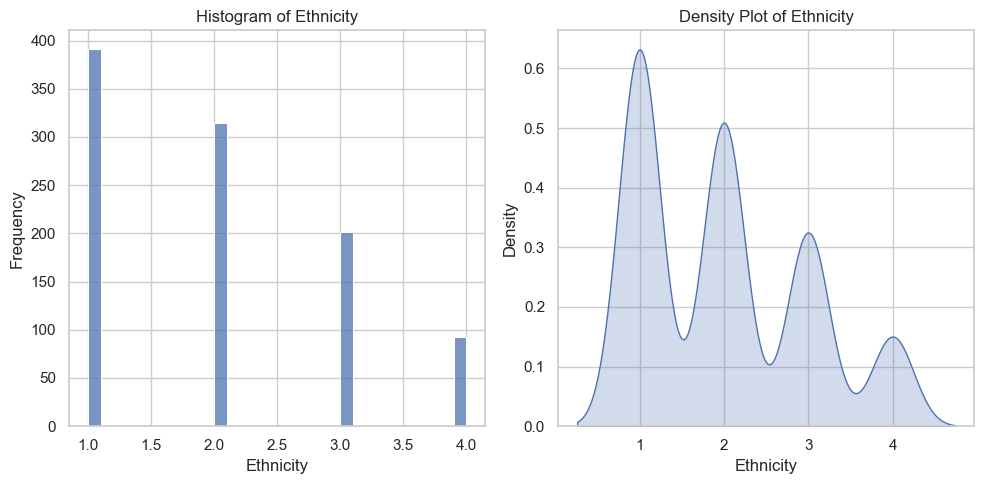

Statistics for Ethnicity:
count    1000.000000
mean        1.996000
std         0.982318
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ethnicity, dtype: float64

Skewness: 0.5984559580712406

Kurtosis: -0.7497835854328416




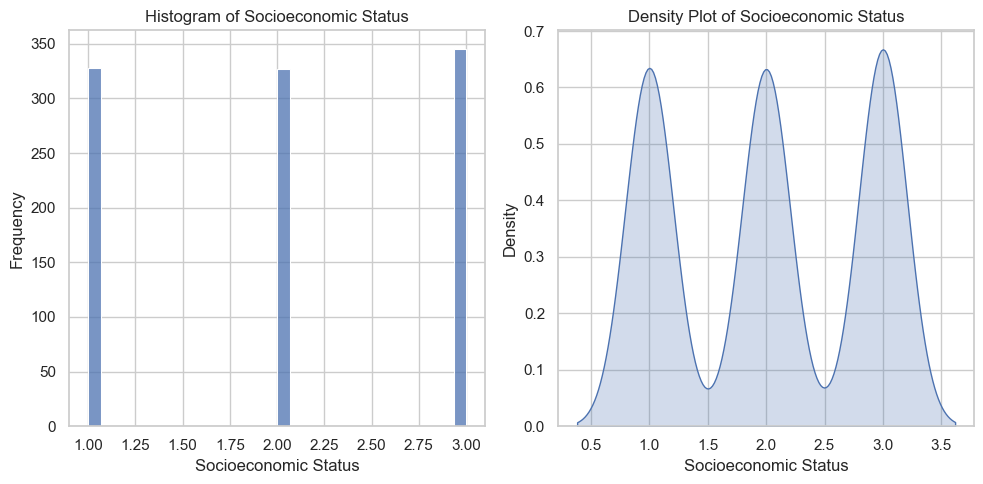

Statistics for Socioeconomic Status:
count    1000.0000
mean        2.0170
std         0.8206
min         1.0000
25%         1.0000
50%         2.0000
75%         3.0000
max         3.0000
Name: Socioeconomic Status, dtype: float64

Skewness: -0.03142578267231947

Kurtosis: -1.514382538084473




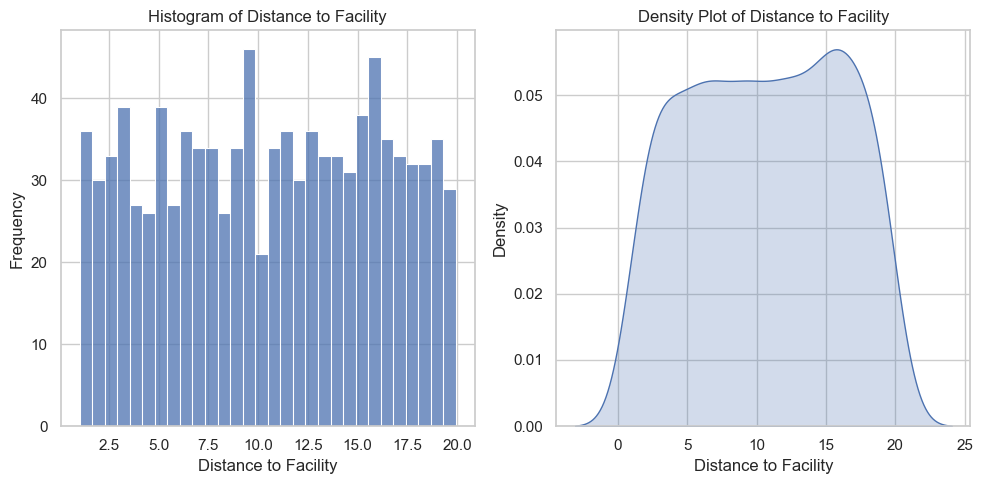

Statistics for Distance to Facility:
count    1000.000000
mean       10.575860
std         5.451377
min         1.030000
25%         5.835000
50%        10.730000
75%        15.375000
max        19.950000
Name: Distance to Facility, dtype: float64

Skewness: -0.04420121981400756

Kurtosis: -1.20015307431305




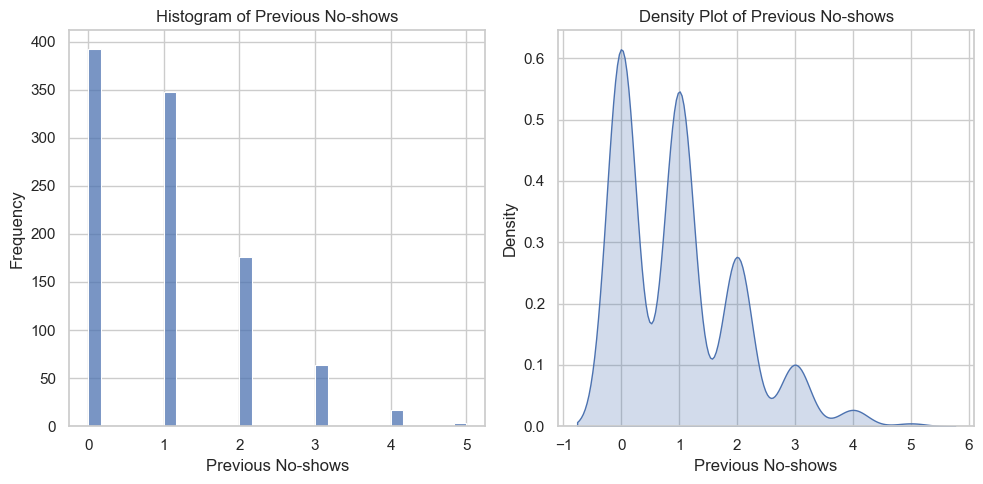

Statistics for Previous No-shows:
count    1000.000000
mean        0.975000
std         1.012621
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: Previous No-shows, dtype: float64

Skewness: 0.9890025923438357

Kurtosis: 0.6644926427285847




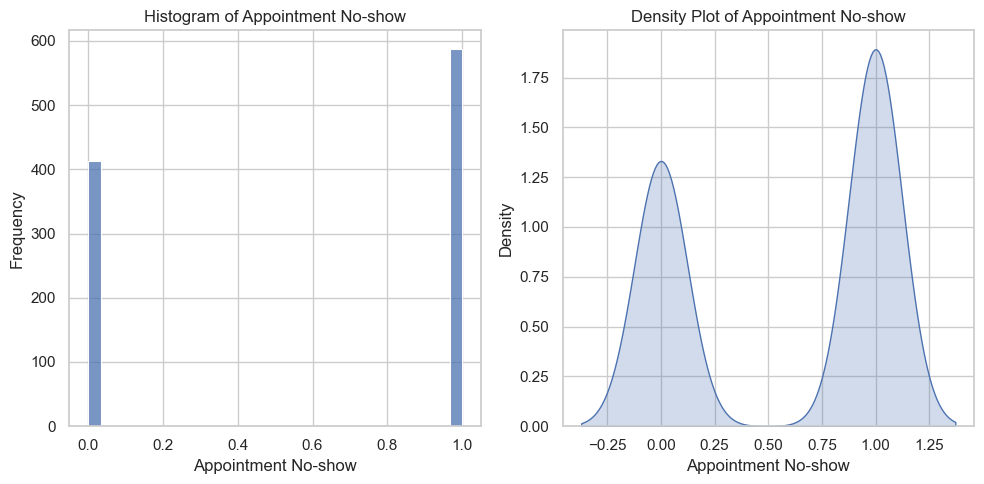

Statistics for Appointment No-show:
count    1000.000000
mean        0.587000
std         0.492619
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Appointment No-show, dtype: float64

Skewness: -0.3539218493826705

Kurtosis: -1.8785003367365811




In [87]:
import seaborn as sns

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions
plot_distributions(df)


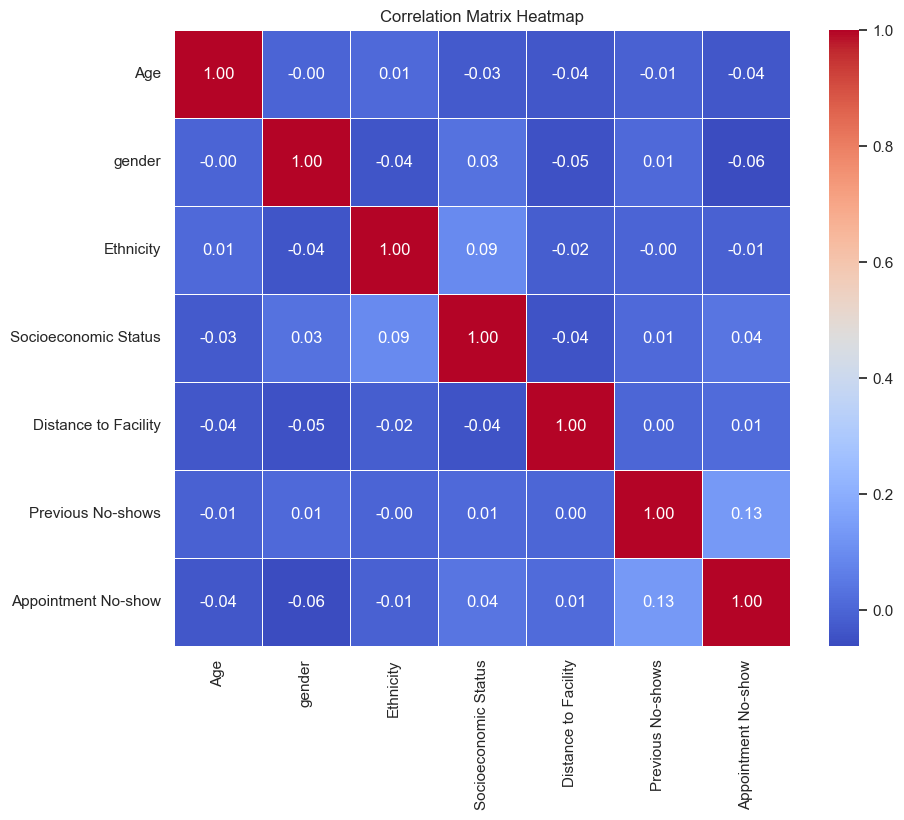

In [88]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [89]:
# Define a function to calculate and display metrics for a given feature
def calculate_metrics(feature):
    print(f"\nMetrics for {feature}:")
    cross_tab = pd.crosstab(df[feature], df['Appointment No-show'])
    cross_tab.columns = ['No-shows No (0)', 'No-shows Yes (1)']
    print(cross_tab)
    
    for value in df[feature].dropna().unique():
        total = cross_tab.loc[value].sum()
        no_shows = cross_tab.loc[value, 'No-shows Yes (1)'] if 'No-shows Yes (1)' in cross_tab.columns else 0
        print(f"\nValue: {value}")
        print(f"Total: {total}")
        print(f"No-shows: {no_shows} ({(no_shows / total) * 100:.2f}%)")
    
    total_no_shows = df[df['Appointment No-show'] == 1].shape[0]
    for value in df[feature].dropna().unique():
        value_no_shows = cross_tab.loc[value, 'No-shows Yes (1)'] if 'No-shows Yes (1)' in cross_tab.columns else 0
        print(f"\nValue: {value}")
        print(f"Number of No-shows: {value_no_shows}")
        print(f"Percentage of Total No-shows: {(value_no_shows / total_no_shows) * 100:.2f}%")

# List of columns to analyze
columns_to_analyze = ['gender', 'Ethnicity', 'Socioeconomic Status', 'Previous No-shows']

# Apply the function to each column
for column in columns_to_analyze:
    calculate_metrics(column)


Metrics for gender:
        No-shows No (0)  No-shows Yes (1)
gender                                   
0.0                 174               280
1.0                 200               250

Value: 0.0
Total: 454
No-shows: 280 (61.67%)

Value: 1.0
Total: 450
No-shows: 250 (55.56%)

Value: 0.0
Number of No-shows: 280
Percentage of Total No-shows: 47.70%

Value: 1.0
Number of No-shows: 250
Percentage of Total No-shows: 42.59%

Metrics for Ethnicity:
           No-shows No (0)  No-shows Yes (1)
Ethnicity                                   
1                      156               235
2                      136               179
3                       83               118
4                       38                55

Value: 3
Total: 201
No-shows: 118 (58.71%)

Value: 4
Total: 93
No-shows: 55 (59.14%)

Value: 1
Total: 391
No-shows: 235 (60.10%)

Value: 2
Total: 315
No-shows: 179 (56.83%)

Value: 3
Number of No-shows: 118
Percentage of Total No-shows: 20.10%

Value: 4
Number of No-shows: 55
P

In [90]:
# Quick overview with Sweetviz
report = sv.analyze(df)
report.show_html('sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


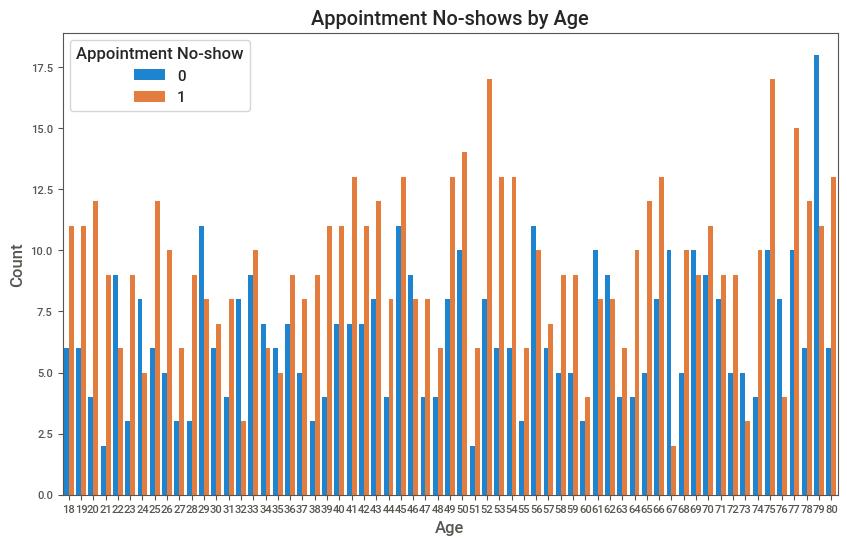

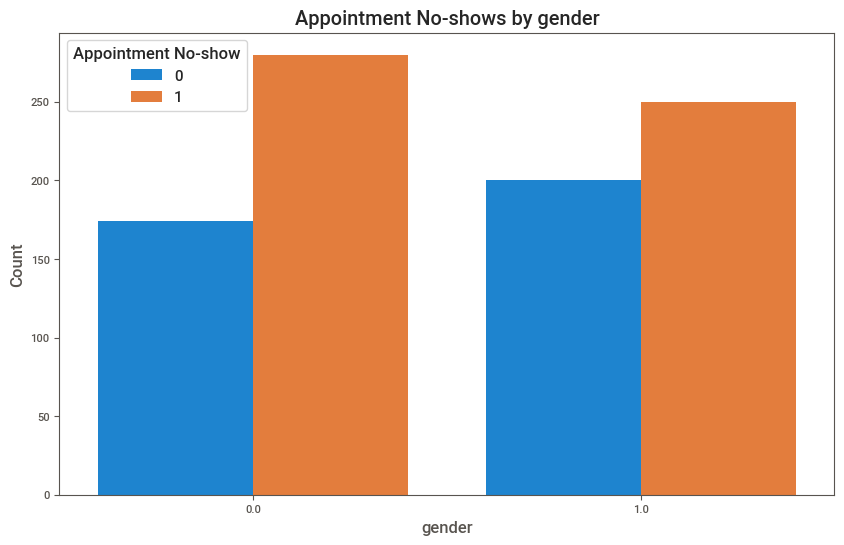

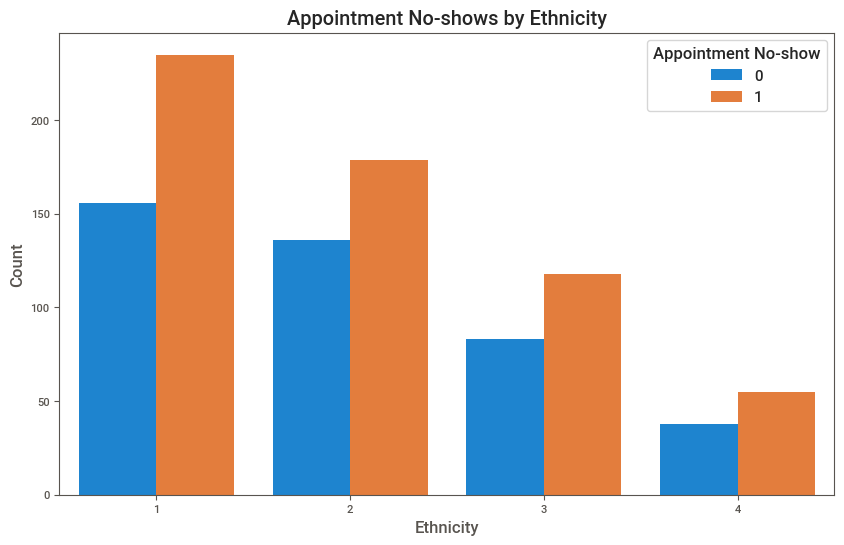

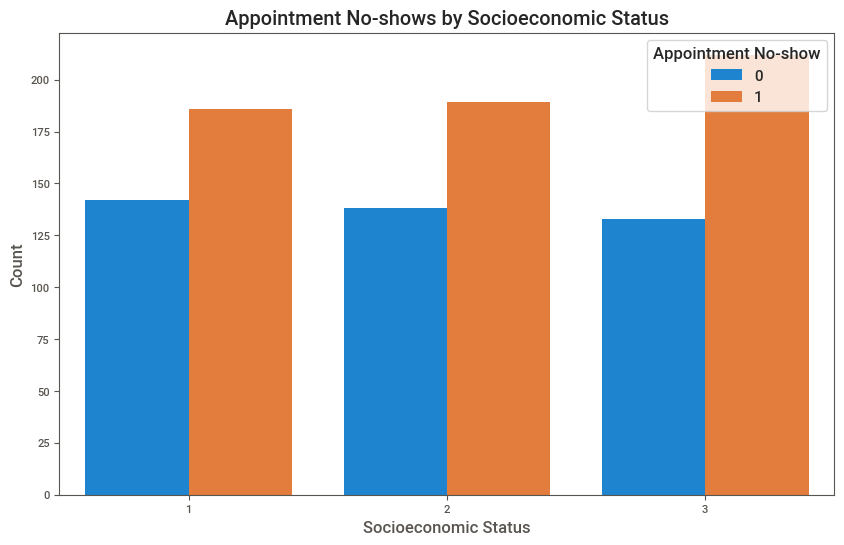

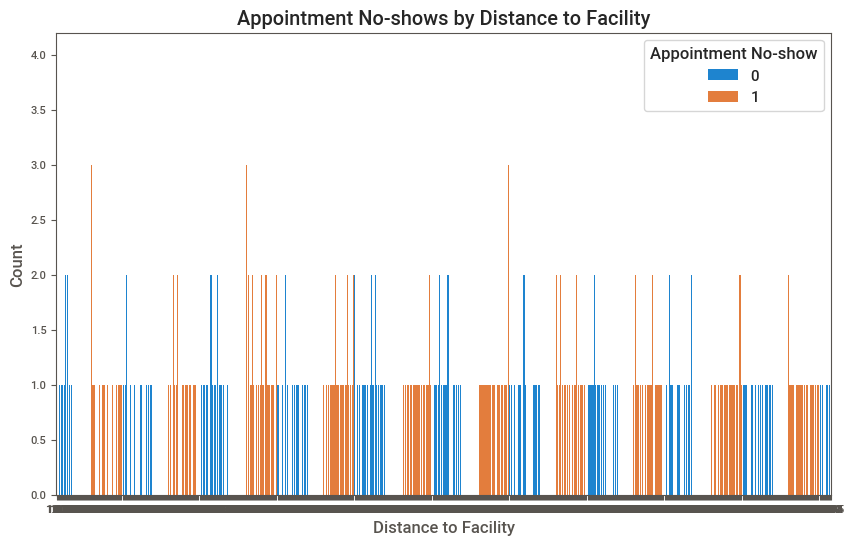

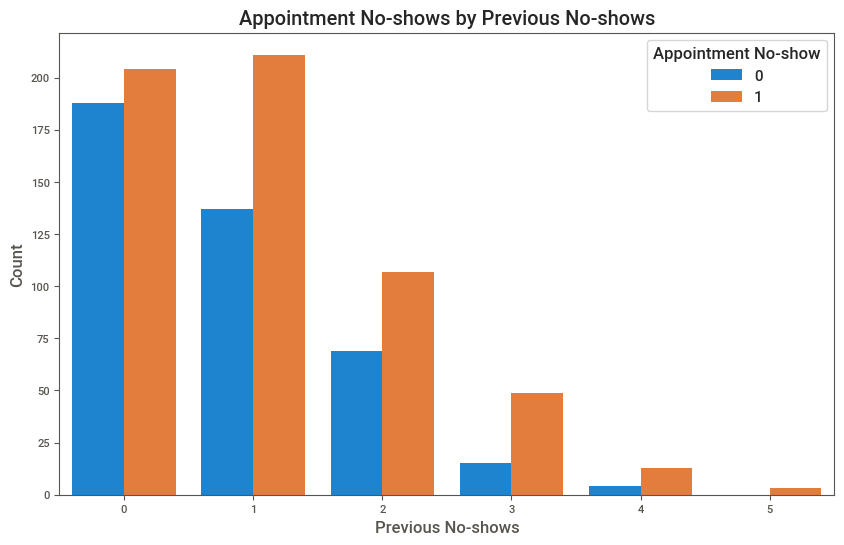

In [91]:
columns_to_plot = ['Age', 'gender', 'Ethnicity', 'Socioeconomic Status', 'Distance to Facility', 'Previous No-shows']

# Plotting
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Appointment No-show', data=df)
    plt.title(f'Appointment No-shows by {column}')
    plt.ylabel('Count')
    plt.show()

# Train-Test Split, TPOT

In [92]:
X = df.drop(columns=['Appointment No-show'])
y = df['Appointment No-show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Export the test set to a CSV file
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv('test_set.csv', index=False)

# Remove the test set from the dataframe
data = pd.concat([X_train, y_train], axis=1)

# Step 5: Use TPOT to find the best model
# Initialize TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=50, random_state=42)

# Fit TPOT on the training data
tpot.fit(X_train, y_train)

# Export the best model pipeline code
tpot.export('tpot_best_model.py')

# Evaluate the best model on the test set
score = tpot.score(X_test, y_test)
print(f'Test Accuracy: {score:.4f}')

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5925

Generation 2 - Current best internal CV score: 0.59375

Generation 3 - Current best internal CV score: 0.59375

Generation 4 - Current best internal CV score: 0.595

Generation 5 - Current best internal CV score: 0.595

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=77, p=1, weights=distance)
Imputing missing values in feature set
Test Accuracy: 0.5750


In [93]:
tpot_data = df.copy()
features = tpot_data.drop('Appointment No-show', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['Appointment No-show'], random_state=42)

imputer = SimpleImputer(strategy="median")
imputer.fit(training_features)
training_features = imputer.transform(training_features)
testing_features = imputer.transform(testing_features)

# Average CV score on the training set was: 0.595
exported_pipeline = KNeighborsClassifier(n_neighbors=77, p=1, weights="distance")
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [94]:
# Make sure 'X' and 'X_test' have the same columns as the training and testing features
X = df.drop('Appointment No-show', axis=1)

# Apply the imputer to handle missing values
X_imputed = imputer.transform(X)
X_test_imputed = imputer.transform(X_test)

# Computing the predicted y for the whole df
y_pred = exported_pipeline.predict(X_imputed)
y_pred_test = exported_pipeline.predict(X_test_imputed)

# Adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred


1000

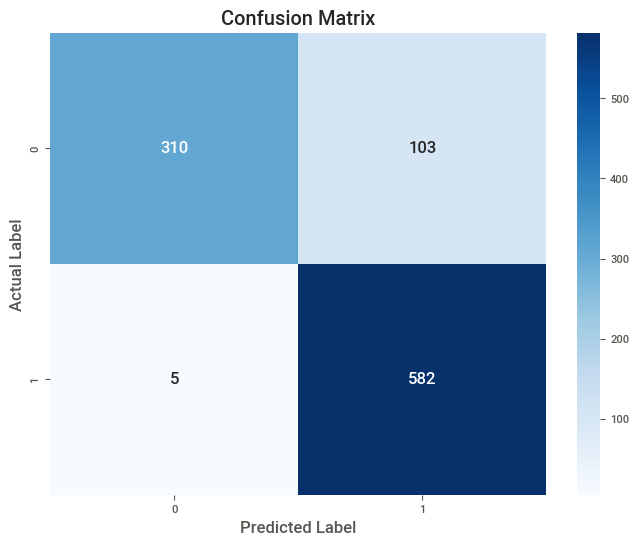

In [95]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

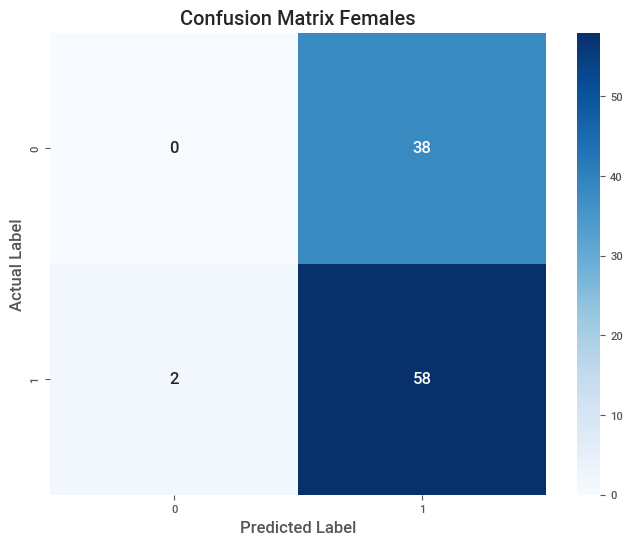

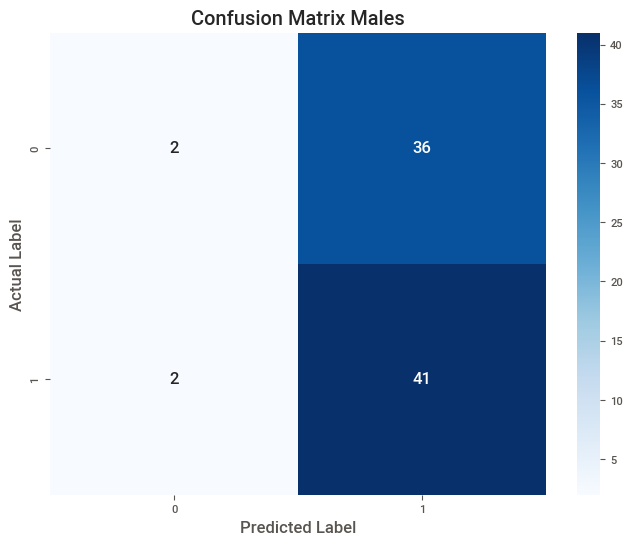

In [102]:
# Create confusion matrices for each gender
y_test_female = y_test[X_test['gender'].values == 0]
y_pred_test_female = y_pred_test[X_test['gender'].values == 0]

y_test_male = y_test[X_test['gender'].values == 1]
y_pred_test_male = y_pred_test[X_test['gender'].values == 1]

cm_female = confusion_matrix(y_test_female, y_pred_test_female)
cm_male = confusion_matrix(y_test_male, y_pred_test_male)

plt.figure(figsize=(8,6))
sns.heatmap(cm_female, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix Females')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(cm_male, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix Males')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [125]:
df.columns

Index(['Age', 'gender', 'Ethnicity', 'Socioeconomic Status',
       'Distance to Facility', 'Previous No-shows', 'Appointment No-show'],
      dtype='object')

In [129]:
# Adding predicted y to the whole df
X_imputed_df = pd.DataFrame(X_imputed, columns=['Age', 'gender', 'Ethnicity', 'Socioeconomic Status',
       'Distance to Facility', 'Previous No-shows'])

df_with_predictions = pd.concat([X_imputed_df, pd.Series(y_pred, name='predictions')], axis=1)
df_with_predictions['predictions'] = exported_pipeline.predict(features)
 
# Display the DataFrame with predictions
print("\nDataFrame with predictions:")
print(df_with_predictions.head())
 
# Analyze gender-based predictions
male_predictions = df_with_predictions[df_with_predictions['gender'] == 0]['predictions']
female_predictions = df_with_predictions[df_with_predictions['gender'] == 1]['predictions']
 
# Print the distribution of predictions for males and females
print("\nDistribution of predictions for males:")
print(male_predictions.value_counts())
 
print("\nDistribution of predictions for females:")
print(female_predictions.value_counts())
 
# Compute confusion matrix for males
cm_male = confusion_matrix(df_with_predictions[df_with_predictions['gender'] == 0]['Appointment No-show'], male_predictions)
 
# Plotting the confusion matrix for males
plt.figure(figsize=(8,6))
sns.heatmap(cm_male, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Males')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
 
# Compute confusion matrix for females
cm_female = confusion_matrix(df_with_predictions[df_with_predictions['gender'] == 1]['Appointment No-show'], female_predictions)
 
# Plotting the confusion matrix for females
plt.figure(figsize=(8,6))
sns.heatmap(cm_female, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Females')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
 
# Print classification report for males
print("\nClassification Report for Males:")
print(classification_report(df_with_predictions[df_with_predictions['gender'] == 0]['Appointment No-show'], male_predictions, target_names=['Absent', 'Present']))
 
# Print classification report for females
print("\nClassification Report for Females:")
print(classification_report(df_with_predictions[df_with_predictions['gender'] == 1]['Appointment No-show'], female_predictions, target_names=['Absent', 'Present']))

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [97]:
print(classification_report(y_test, y_pred_test, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       0.43      0.03      0.06        86
     Present       0.57      0.96      0.72       114

    accuracy                           0.56       200
   macro avg       0.50      0.50      0.39       200
weighted avg       0.51      0.56      0.44       200



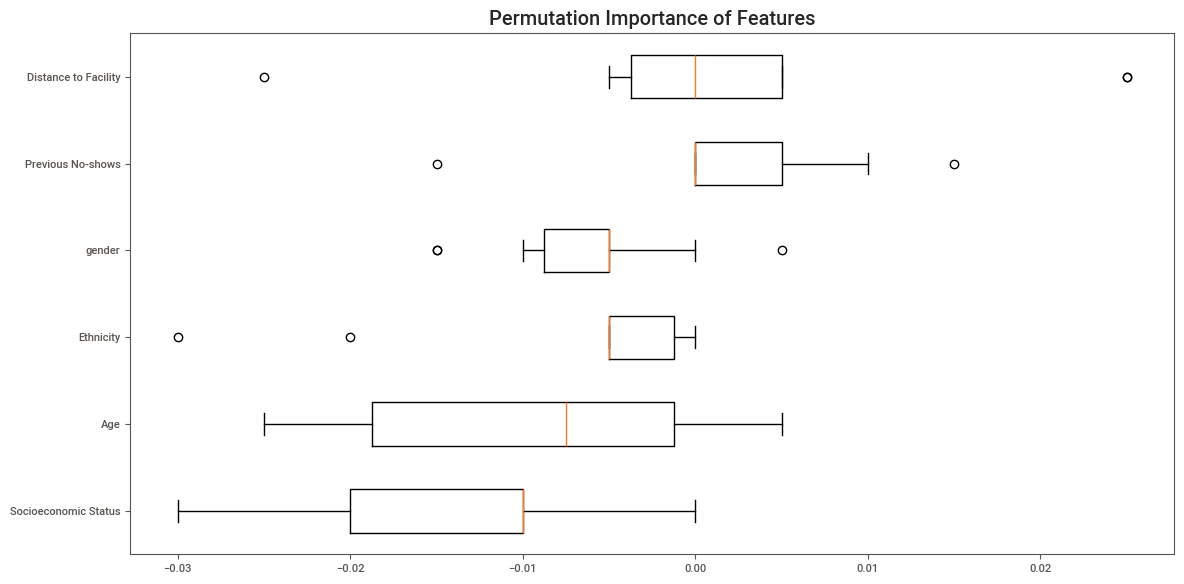

In [106]:
result = permutation_importance(exported_pipeline, X_test_imputed, y_test, n_repeats=10, random_state=42)
sorted = result.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.boxplot(result.importances[sorted].T, vert=False, labels=X_test.columns[sorted])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



In [109]:
# AIF360 imports
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# Other necessary imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pip install 'aif360[inFairness]'


In [116]:
X.columns

Index(['Age', 'gender', 'Ethnicity', 'Socioeconomic Status',
       'Distance to Facility', 'Previous No-shows'],
      dtype='object')

In [120]:
# Assuming 'gender' is the sensitive attribute and 'target' is the target variable
sensitive_attribute = 'gender'
target_variable = 'Appointment No-show'



X_imputed_df = pd.DataFrame(X_imputed, columns=['Age', 'gender', 'Ethnicity', 'Socioeconomic Status',
       'Distance to Facility', 'Previous No-shows'])  # Use appropriate column names


# Concatenate the DataFrame and y
df_imputed = pd.concat([X_imputed_df, y], axis=1)


# Convert your dataset to AIF360's BinaryLabelDataset
bld = BinaryLabelDataset(
    df=df_imputed,
    label_names=[target_variable],
    protected_attribute_names=[sensitive_attribute]
)

# Display basic information about the dataset
print(bld)

               instance weights features                                \
                                         protected attribute             
                                     Age              gender Ethnicity   
instance names                                                           
0                           1.0     56.0                 0.0       3.0   
1                           1.0     69.0                 1.0       3.0   
2                           1.0     46.0                 1.0       4.0   
3                           1.0     32.0                 0.0       1.0   
4                           1.0     60.0                 1.0       1.0   
...                         ...      ...                 ...       ...   
995                         1.0     78.0                 1.0       1.0   
996                         1.0     23.0                 0.0       3.0   
997                         1.0     35.0                 0.0       2.0   
998                         1.0     68

In [121]:
# Define privileged and unprivileged groups
privileged_groups = [{sensitive_attribute: 1}]  # Assuming 1 represents the privileged group
unprivileged_groups = [{sensitive_attribute: 0}]  # Assuming 0 represents the unprivileged group

# Compute bias metrics
metric = BinaryLabelDatasetMetric(bld, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
mean_difference = metric.mean_difference()

print(f"Difference in mean outcomes: {mean_difference:.4f}")

Difference in mean outcomes: 0.0545
